In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline
from datetime import datetime
import time
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

1. split into train and test
2. recreate target column
3. perform dickey-fuller test
4. build linear model and evaluate(RMSE,Adjusted R^2)

In [2]:
df=pd.read_csv('/Users/yijun/Documents/NYU/1007/hw/project/train.csv')
info = pd.read_csv('/Users/yijun/Documents/NYU/1007/hw/project/asset_details.csv')

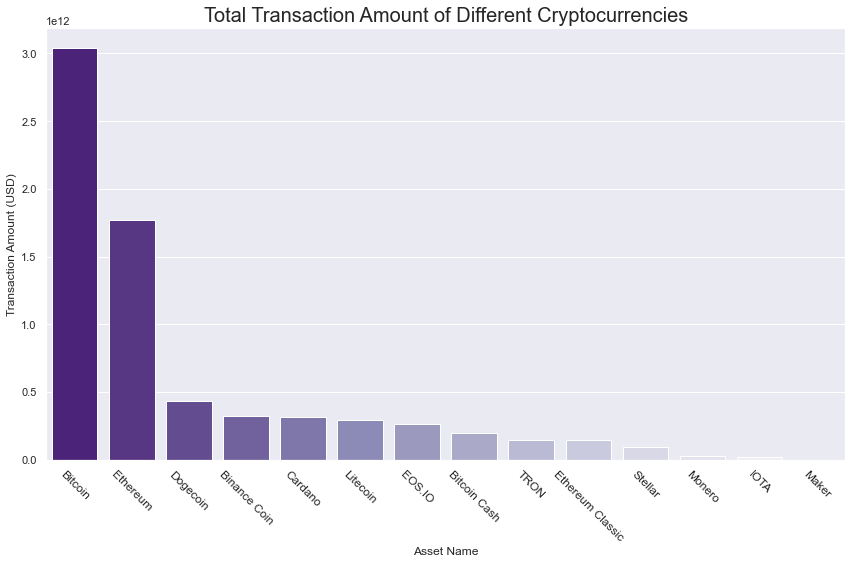

In [5]:
d_ = {key:value for key, value in zip(info['Asset_ID'], info['Asset_Name'])}
data_new = df[df['VWAP'].notna()]
data_new['Amount'] = data_new['Volume']*data_new['VWAP']
d = data_new.groupby(['Asset_ID']).sum()['Amount']
d_new = d.rename(index=d_)
d_new=d_new.sort_values(ascending=False)

sns.set(rc={'figure.figsize':(12,8)})
sns.barplot(x =d_new.index, y = d_new,palette ='Purples_r')
plt.title('Total Transaction Amount of Different Cryptocurrencies',fontsize=20)
plt.xlabel('Asset Name')
plt.ylabel('Transaction Amount (USD)')
plt.xticks(
    rotation=-45,
    fontweight='light',
    fontsize='medium',
)
plt.tight_layout()
plt.show()

In [6]:
bitcoin_datetime = df[df["Asset_ID"]==1].set_index(df[df["Asset_ID"]==1]['timestamp'].apply(lambda x: datetime.fromtimestamp(x)))
bitcoin_datetime.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,,
2017-12-31 19:01:00,1514764860,1,229.0,13835.194,14013.8,13666.11,13850.176,31.550062,13827.062093,-0.014643
2017-12-31 19:02:00,1514764920,1,235.0,13835.036,14052.3,13680.00,13828.102,31.046432,13840.362591,-0.015037
2017-12-31 19:03:00,1514764980,1,528.0,13823.900,14000.4,13601.00,13801.314,55.061820,13806.068014,-0.010309
2017-12-31 19:04:00,1514765040,1,435.0,13802.512,13999.0,13576.28,13768.040,38.780529,13783.598101,-0.008999
2017-12-31 19:05:00,1514765100,1,742.0,13766.000,13955.9,13554.44,13724.914,108.501637,13735.586842,-0.008079


In [17]:
bitcoin = df[df["Asset_ID"]==1].set_index("timestamp")

[Text(0.5, 1.0, 'Volume'), Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

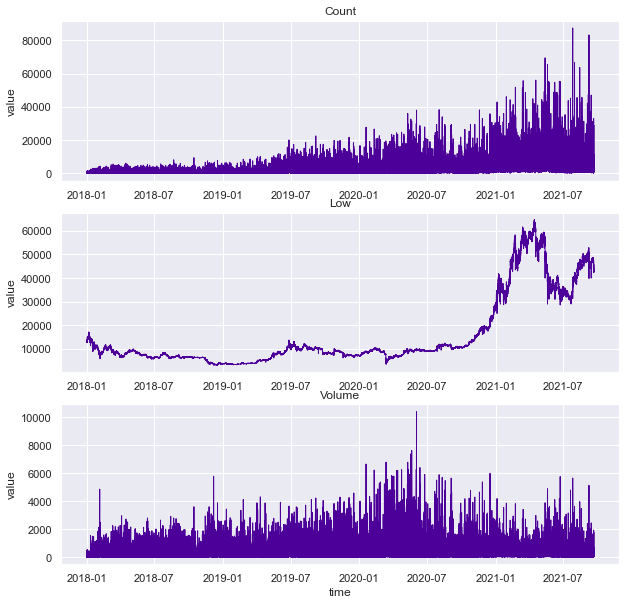

In [11]:
#original time series plots of all of the features

f, axes = plt.subplots(nrows=3, ncols=1,figsize = [10, 10])
x=bitcoin_datetime.index
y=bitcoin_datetime['Count']
axes[0].plot(x, y, color = [0.3,0,0.6], linewidth = 1)
axes[0].set(title='Count', ylabel='value')



y=bitcoin_datetime['Low']
axes[1].plot(x, y, color = [0.3,0,0.6], linewidth = 1)
axes[1].set(title='Low', ylabel='value')


y=bitcoin_datetime['Volume']
axes[2].plot(x, y, color = [0.3,0,0.6], linewidth = 1)
axes[2].set(title='Volume', xlabel='time', ylabel='value')


[Text(0.5, 1.0, 'VWAP'), Text(0.5, 0, 'time'), Text(0, 0.5, 'value')]

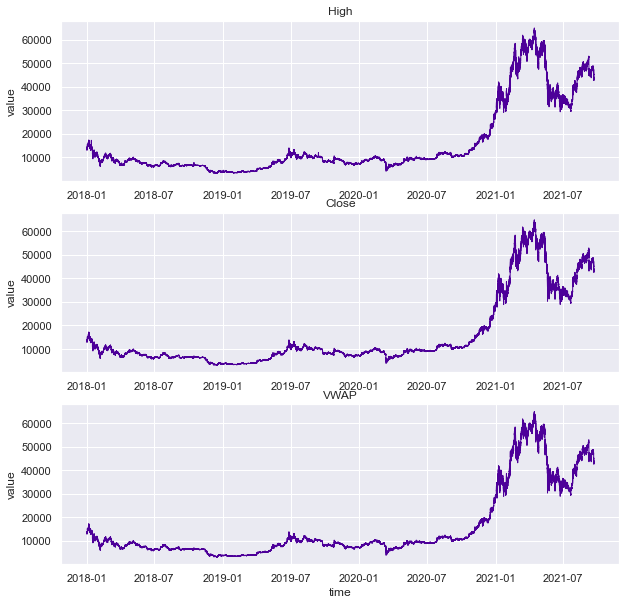

In [12]:
f, axes = plt.subplots(nrows=3, ncols=1,figsize = [10, 10])
x=bitcoin_datetime.index
y=bitcoin_datetime['High']
axes[0].plot(x, y, color = [0.3,0,0.6], linewidth = 1)
axes[0].set(title='High', ylabel='value')

y=bitcoin_datetime['Close']
axes[1].plot(x, y, color = [0.3,0,0.6], linewidth = 1)
axes[1].set(title='Close', ylabel='value')

y=bitcoin_datetime['VWAP']
axes[2].plot(x, y, color = [0.3,0,0.6], linewidth = 1)
axes[2].set(title='VWAP', xlabel='time', ylabel='value')

## Fill in data for gaps

In [18]:
#check timestamp difference if any missing
(bitcoin.index[1:]-bitcoin.index[:-1]).value_counts().head()


60     1956136
120         78
180         12
240         11
420          9
Name: timestamp, dtype: int64

In [19]:
#deal with missing data-filling the gaps with the previous valid value
bitcoin = bitcoin.reindex(range(bitcoin.index[0],bitcoin.index[-1]+60,60),method='pad')

#check if any missing val
(bitcoin.index[1:]-bitcoin.index[:-1]).value_counts().head()


60    1956959
Name: timestamp, dtype: int64

# recalculate the target column

In [24]:
bitcoin['Target'] = np.log(bitcoin.Close.shift(-15)) - np.log(bitcoin.Close)

In [25]:
beg_btc = bitcoin.index[0].astype('datetime64[s]')
end_btc = bitcoin.index[-1].astype('datetime64[s]')
print('Bitcoin data goes from ', beg_btc, 'to ', end_btc)


Bitcoin data goes from  2018-01-01T00:01:00 to  2021-09-21T00:00:00


In [26]:
bitcoin.index

Int64Index([1514764860, 1514764920, 1514764980, 1514765040, 1514765100,
            1514765160, 1514765220, 1514765280, 1514765340, 1514765400,
            ...
            1632181860, 1632181920, 1632181980, 1632182040, 1632182100,
            1632182160, 1632182220, 1632182280, 1632182340, 1632182400],
           dtype='int64', name='timestamp', length=1956282)

# Visualize new Target 

Text(0.5, 1.0, 'Target -- Residual log-returns for bitcoin over 15mins duration ')

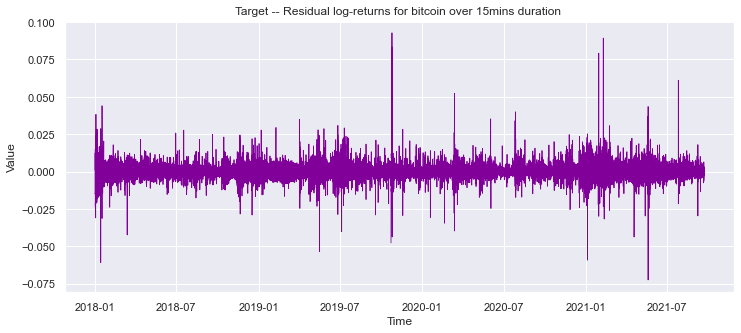

In [25]:
#plot target
f,axes = plt.subplots(nrows=1, ncols=1,figsize = [12, 5])

x = bitcoin_datetime.index
y = bitcoin_datetime['Target']

plt.plot(x, y, color = [0.5,0,0.6], linewidth = 0.8)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Target -- Residual log-returns for bitcoin over 15mins duration ')

In [39]:
bitcoin.Close

timestamp
1514764860    13850.176000
1514764920    13828.102000
1514764980    13801.314000
1514765040    13768.040000
1514765100    13724.914000
                  ...     
1632182160    42899.012857
1632182220    42860.005714
1632182280    42827.020000
1632182340    43017.277143
1632182400    43002.505000
Name: Close, Length: 1956960, dtype: float64

In [20]:
#totimestamp= lambda s: np.int32(time.mktime(datetime.strptime(s,"%d/%m/%Y").timetuple()))

def duration(start,end,data):
    df=data.loc[totimestamp(start): totimestamp(end)]
    return df

btc2020= duration(start="01/01/2020", end="31/12/2020", data=bitcoin)

<module 'matplotlib.pyplot' from '/Users/yijun/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

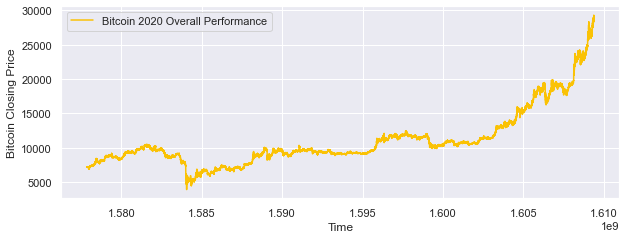

In [36]:
#plot the closing price for bitcoin
f= plt.figure(figsize=(10,12))  

def gplot(no, data, price, label, ylabel, color):
    ax=f.add_subplot(no)
    plt.plot(data[price], label=label, color=color)
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel(ylabel)
    return plt

gplot(no=311, data=btc2020, price="Close" , label="Bitcoin 2020 Overall Performance", ylabel="Bitcoin Closing Price", color="#fac205")

<module 'matplotlib.pyplot' from '/Users/yijun/opt/anaconda3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

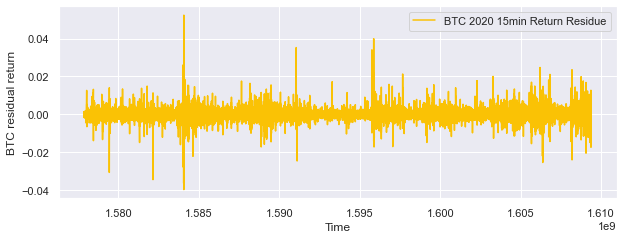

In [35]:
f= plt.figure(figsize=(10,12))  
gplot(no=311, data=btc2020, price="Target" , label="BTC 2020 15min Return Residue", ylabel="BTC residual return", color="#fac205")

In [43]:
def sub(asset_id ,data= df):
    df = data[data["Asset_ID"]==asset_id].reset_index(drop = True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df.set_index('timestamp')
    return df

bitcoin1=sub(asset_id=1)

In [44]:
def data(data):
    df=data[["Low","High","Open","Close"]]
    return df

bitcoin1=data(bitcoin1)

BTC Seasonal Decomposition


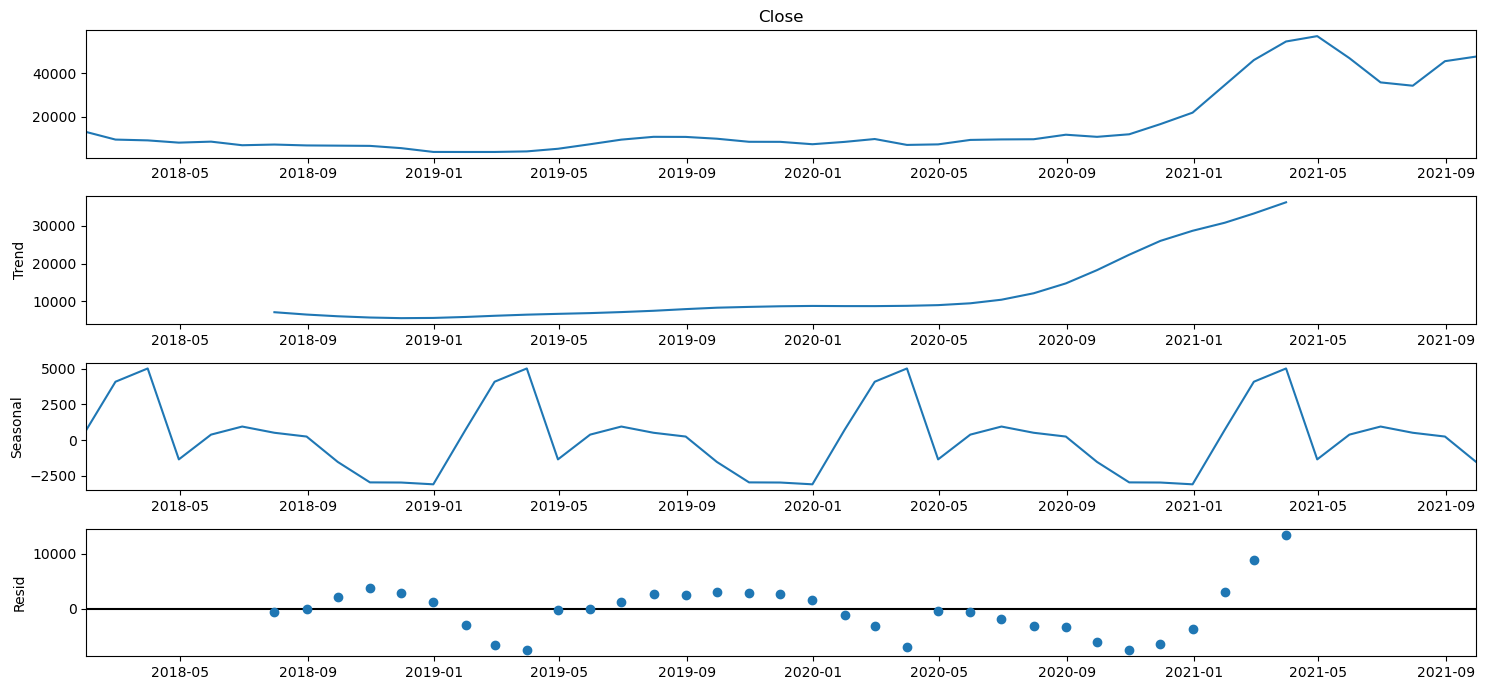

In [45]:
plt.rcParams["figure.figsize"]=(15,8)

def season(data, label):
    df=data.resample("M").mean()
    seasonal_decompose(df.Close).plot()
    print(label)
    return plt.show()

season(data=bitcoin1, label="BTC Seasonal Decomposition")

# split into train and test set with the following criteria
1. Train: all data within year 2020 
2. Test: first three months in 2021

In [46]:
bitcoin = bitcoin.reset_index()
bitcoin.dtypes

timestamp      int64
Asset_ID       int64
Count        float64
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
VWAP         float64
Target       float64
dtype: object

In [47]:
int(datetime(2020, 1, 1).timestamp())

1577854800

In [48]:
# get training and testing set
train = bitcoin[(bitcoin['timestamp']>=int(datetime(2020, 1, 1).timestamp())) & (bitcoin['timestamp']<=int(datetime(2020, 12, 31).timestamp()))]
test = bitcoin[(bitcoin['timestamp']>=int(datetime(2021, 1, 1).timestamp())) & (bitcoin['timestamp']<=int(datetime(2021, 3, 31).timestamp()))]

In [49]:
# output train and test set to local path
# train.to_csv('data/train.csv')
# test.to_csv('data/test.csv')

# Perform Dickey-Fuller test to test whether our data is stationary in order to use ARIMA 

In [51]:
train

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
1051499,1577854800,1,175.0,7207.469036,7225.728479,7183.850000,7208.886926,9.715036,7208.425856,0.000150
1051500,1577854860,1,279.0,7209.065000,7225.803515,7188.120000,7210.176689,35.847267,7209.838574,0.000227
1051501,1577854920,1,297.0,7213.312253,7228.585154,7191.580000,7216.222526,24.931803,7214.863917,-0.000618
1051502,1577854980,1,219.0,7216.094286,7230.000000,7196.120000,7216.701429,8.575068,7216.742884,-0.000675
1051503,1577855040,1,254.0,7216.587143,7230.000000,7193.770000,7215.621429,14.747965,7215.919669,0.000220
...,...,...,...,...,...,...,...,...,...,...
1577095,1609390560,1,1834.0,28991.386250,29057.070000,28914.180000,29013.432500,75.390369,29005.428306,-0.003111
1577096,1609390620,1,1297.0,29024.321429,29056.730000,28992.719613,29028.482857,60.874054,29030.555036,-0.003331
1577097,1609390680,1,1510.0,29031.370000,29051.520000,28948.000000,29003.657143,60.245689,29005.201877,-0.003658
1577098,1609390740,1,1014.0,29004.294286,29046.920000,28959.000000,29019.580000,47.773633,29013.827671,-0.003422


In [53]:
result = adfuller(train['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 4.268637
p-value: 1.000000


Since the p-value is greater than 0.05, this indicates that the Close time series data is non-stationary. We'll move on to linear regression model that does not require stationary.

# Fit a linear regression model and Evaluate

In [63]:
train_X = train.drop(columns = ['timestamp', 'Asset_ID', 'Target'])
train_y = train['Target']
test_X = test.drop(columns = ['timestamp', 'Asset_ID', 'Target'])
test_y = test['Target']
reg = LinearRegression().fit(train_X, train_y)

In [61]:
# evaluation on training set
print('R^2 for training data:',r2_score(train_y, reg.predict(train_X)))
print('RMSE for training data:',mean_squared_error(train_y, reg.predict(train_X)))

R^2 for training data: 0.001050962587423765
RMSE for training data: 1.6087421603081853e-05


In [64]:
# evaluation on testing set
print('R^2 for testing data:',r2_score(test_y, reg.predict(test_X)))
print('RMSE for testing data:',mean_squared_error(test_y, reg.predict(test_X)))

R^2 for training data: -0.0002910968522435997
RMSE for training data: 3.827890750977448e-05


# Fit a ramdom forest model and Evaluate

In [68]:
regr = RandomForestRegressor(n_jobs=-1).fit(train_X, train_y)

In [69]:
# evaluation on training set
print('R^2 for training data:',r2_score(train_y, regr.predict(train_X)))
print('RMSE for training data:',mean_squared_error(train_y, regr.predict(train_X)))

R^2 for training data: 0.8757930797814761
RMSE for training data: 2.0002713018787176e-06


In [71]:
# evaluation on testing set
print('R^2 for testing data:',r2_score(test_y, regr.predict(test_X)))
print('RMSE for testing data:',mean_squared_error(test_y, regr.predict(test_X)))

R^2 for testing data: -3.262195652291818
RMSE for testing data: 0.00016310471389384084
